In [1]:
import numpy as np
import GPy
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn.apionly as sns #import seaborn

Let's define a high fidelity model that we'll imagine is expensive

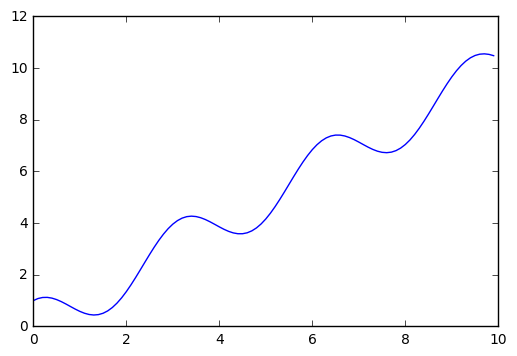

In [2]:
def f1(x):
    return x+np.cos(x*2.)
    
x = np.arange(0,10,0.1)
plt.plot(x, f1(x))

We imagine we want to estimate
$$E(f_1(X))$$
where $X\sim U[0,10]$.

We know the MC estimator is unbiased, and so $MSE({\hat s}) = var(s)= \sigma_1^2/n$

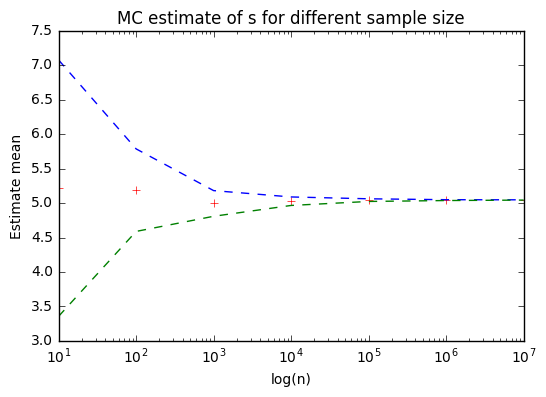

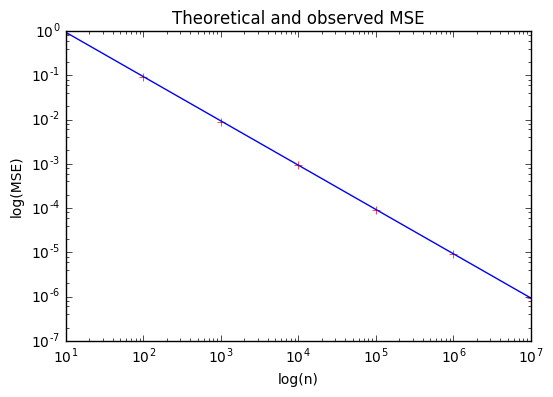

In [4]:
def MC(nsamp):
    xsamp = np.random.uniform(0,10,nsamp)
    ysamp = f1(xsamp)
    return(np.mean(ysamp), np.var(ysamp)/nsamp)

sigma1 = np.var(f1(np.random.uniform(0,10,10**7)))
vals = np.array([10,100,1000,10**4, 10**5, 10**6, 10**7])
means = np.zeros(vals.size)
vars = np.zeros(vals.size)
for i, n in enumerate(vals):
    means[i], vars[i] = MC(n)

plt.semilogx(vals, means, 'r+')
#plt.loglog(vals,sigma1/vals)
plt.xlabel('log(n)')
plt.ylabel('Estimate mean')
plt.semilogx(vals, means+2*np.sqrt(vars), '--')
plt.semilogx(vals, means-2*np.sqrt(vars), '--')
plt.title('MC estimate of s for different sample size')

plt.figure(2)
plt.loglog(vals, vars, 'r+')
plt.loglog(vals,sigma1/vals)
plt.xlabel('log(n)')
plt.ylabel('log(MSE)')
plt.title('Theoretical and observed MSE')


Now let's build a surrogate model, $f_2$, for the high fidelity simulator. I'll use a GP.


Name : GP regression
Objective : 18.16455658966451
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |   103.435561959  |      +ve      |        
  rbf.lengthscale          |   13.9701233372  |      +ve      |        
  Gaussian_noise.variance  |  0.618668634969  |      +ve      |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


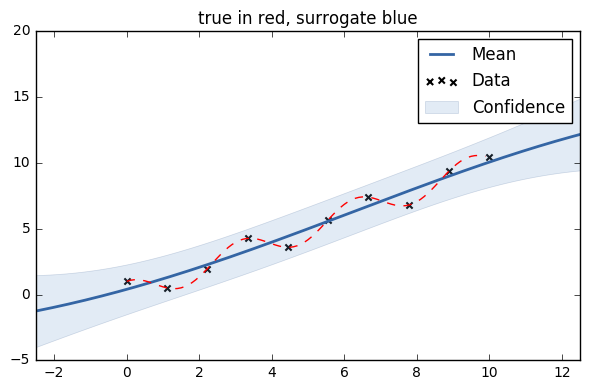

In [6]:
ntrain = 10#5
xtrain = np.linspace(0,10,ntrain)
ytrain = f1(xtrain)
k = GPy.kern.RBF(1)
m = GPy.models.GPRegression(xtrain[:,None],ytrain[:,None], k)
m.optimize()
m.plot()
print(m)
plt.plot(x, f1(x), 'r--')
plt.title('true in red, surrogate blue')

Now we'll look at the correlation between the simulator and the emulator. To begin with, I'll forget about doing this efficiently, and just estimate it using a large number of samples. Note that this needs an additional training set, separate to that used to train the emulator. We can't use the emulator training set in estimating the correlation, as the emulator interpolates perfectly, and so the correlation would be 1 if we just reused these points. It's unclear to me whether something like cross-validation would work or not.

In [7]:
xsamp = np.random.uniform(0,10,1000)
ysamp = f1(xsamp)
ypred, _ = m.predict_noiseless(xsamp[:,None])
sigma2 = np.var(ypred)
print(sigma2)

8.3774169357


In [8]:
rho12, _ = stats.pearsonr(ypred.flatten(),ysamp)
print(rho12)

0.975060752802


Set the costs arbitrarily. We'll assume the simulator is very expensive compared to the full simulator.

In [9]:
w1 = 1
w2 = 10**-5

Check ratio condition is satisfied. We need $w_1/w_2=1/w_2$ to be greater than

In [10]:
(1.-rho12**2)/rho12**2

0.0518084318368814

Or equivalently, $w_2$ needs to be great than

In [11]:
rho12**2/(1.-rho12**2)

19.301877407687133

Now set the $\alpha$ and $m$.

In [12]:
alpha2 = rho12*np.sqrt(sigma1)/np.sqrt(sigma2)
print(alpha2)

r1 = 1
r2 = np.sqrt(w1*rho12**2/(w2*(1-rho12**2)))
print(r2)

1.02550925984
1389.31196668


Set the total computational budget, and calculate how many runs to do.

In [13]:
p = 10**1 # Total budget
m1 = p/(w1*r1+w2*r2)
m2 = m1*r2
m1=np.floor(m1).astype('int')
m2 = np.floor(m2).astype('int')
print(m1,m2)

9 13702


In [17]:
def MFMC(m1, m2, alpha2):
    Z = np.random.uniform(0,10,m2)
    y1 = f1(Z[:m1])

    y2, _ = m.predict(Z[:,None])
    y2 = y2.flatten()
    y1_bar = np.mean(y1)
    y2_bar1 = np.mean(y2[:m1])
    y2_bar2 = np.mean(y2)
    return(y1_bar + alpha2*(y2_bar2-y2_bar1), y2_bar2)
    

In [18]:
MFMC_out = np.zeros(100)
GP_only = np.zeros(100)
MC_out = np.zeros(100)
for ii in np.arange(100):
    MFMC_out[ii], y2_bar2= MFMC(m1,m2, alpha2)
    MC_out[ii],_ = MC(p)
    GP_only[ii] = np.mean(y2_bar2)

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future


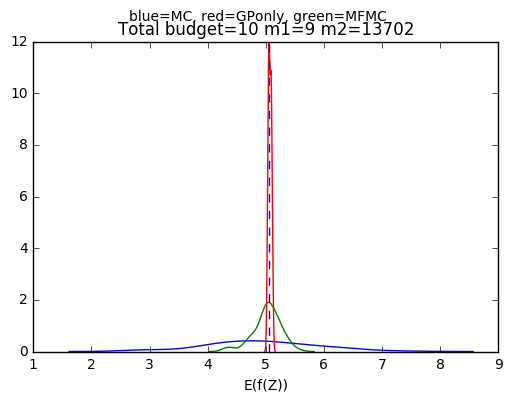

In [19]:

kde1=sns.kdeplot(MC_out, color='b')
kde2=sns.kdeplot(MFMC_out,color='g')
kde3=sns.kdeplot(GP_only,color='r')
plt.xlabel('E(f(Z))')
plt.axvline(means[-1], linestyle='--')
plt.title('Total budget='+str(p)+' m1='+str(m1)+' m2='+str(m2))
plt.suptitle('blue=MC, red=GPonly, green=MFMC')

## Problems

- The paper doesn't deal with the problem of estimating $\sigma_i^2$ and $\rho_{1,i}$. If we get these values wrong, then the benefits of MFMC reduce, or even disappear. Estimating these values well is harder than estimating $s=E(f_1(Z))$, and so the method relies on the MFMC estimator being insensitive to small errors in the correlations and variances.


## Notes on when $f_2$ is a GP emulator.

- This requires either 2 or 3 sets of evaluations of $f_1$. Firstly, we need a reasonable number of evaluations of $f_1$ to train the emulator. Secondly, we need a set of evaluations to estimate the correlations and variances. Finally, we need the evaluations to form the MFMC estimator. It wasn't clear to me whether the second and third sets can be the same, and then whether an adaptive approach would allow us to choose the number of evaluations on the fly.  But we can't use the same runs in the first and second sets, because the GP emulator interpolates. It is possible a cross-validation type scheme could be made to work.

- Typically we build  GP emulators with a relatively small number of simulator evaluations. This approach relies on us having a large enough test set, not used in training the GP, to estimate the correlation with the high-fidelity simulator. Its not clear whether if we instead just used these to build the emulator, we'd reduce the error in the emulator sufficiently to avoid any serious bias. 

- If the emulator is good, then the MFMC estimator is worse than just using the emulator. 
- But if the emulator is poor (which is more likely in high dimensions), or the UQ for it is poor, then MFMC seems to work well in correcting the bias in our estimate.



In [20]:
def Repeat_MFMC(w1, w2, p, f1, f2, nrep=1):
    'f a simple 1d function'
    'f2 a fitted model from GPy'
    xsamp = np.random.uniform(0,10,1000)
    ysamp = f1(xsamp)
    ypred, _ = f2.predict_noiseless(xsamp[:,None])
    sigma2 = np.var(ypred)
    sigma1 = np.var(ysamp)
    rho12, _ = stats.pearsonr(ypred.flatten(),ysamp)
    if  w1/w2 <= (1.-rho12**2)/rho12**2:
        print('warning constraints not satisfied')
    alpha2 = rho12*np.sqrt(sigma1)/np.sqrt(sigma2)
    r1 = 1
    r2 = np.sqrt(w1*rho12**2/(w2*(1-rho12**2)))
    m1 = p/(w1*r1+w2*r2)
    m2 = m1*r2
    m1=np.floor(m1).astype('int')
    m2 = np.floor(m2).astype('int')
    print('Doing the following number of evaluations', m1,m2)
    
    MFMC=np.zeros(nrep)
    MC = np.zeros(nrep)
    GP_only = np.zeros(nrep)
    for nn in range(nrep):
        Z = np.random.uniform(0,10,m2)
        y1 = f1(Z[:m1])

        y2, _ = f2.predict(Z[:,None])
        y2 = y2.flatten()
        y1_bar = np.mean(y1)
        y2_bar1 = np.mean(y2[:m1])
        y2_bar2 = np.mean(y2)
    
        m_MC = int(p/w1)
    
        # returns MFMC, MC, and GP (not the same budget)
        MFMC[nn] = y1_bar + alpha2*(y2_bar2-y2_bar1)
        MC[nn]=np.mean(f1(Z[:m_MC]))
        GP_only[nn] = y2_bar2
    return(MFMC, MC, GP_only)



Name : GP regression
Objective : 9.10747193636535
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  rbf.variance             |      61.1810358399  |      +ve      |        
  rbf.lengthscale          |        7.603501662  |      +ve      |        
  Gaussian_noise.variance  |  6.67037183961e-45  |      +ve      |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


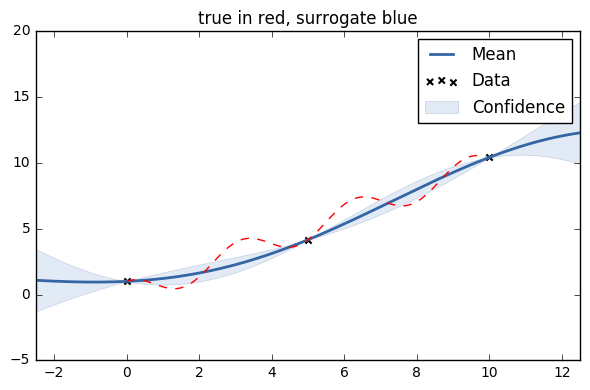

In [23]:

ntrain = 3 #5
xtrain = np.linspace(0,10,ntrain)
ytrain = f1(xtrain)
k = GPy.kern.RBF(1)
m = GPy.models.GPRegression(xtrain[:,None],ytrain[:,None], k)
m.optimize()
m.plot()
print(m)
plt.plot(x, f1(x), 'r--')
plt.title('true in red, surrogate blue')


In [25]:
p = 10**1 # Total budget
w1=1
w2=10**-5

MFMC, MC, GP_only = Repeat_MFMC(w1,w2, p,f,m,100)
kde1=sns.kdeplot(MC, color='b')
kde2=sns.kdeplot(MFMC,color='g')
kde3=sns.kdeplot(GP_only,color='r')
plt.xlabel('E(f(Z))')
plt.axvline(means[-1], linestyle='--')
plt.title('Total budget='+str(p)+' m1='+str(m1)+' m2='+str(m2))
plt.suptitle('blue=MC, red=GPonly, green=MFMC')

NameError: name 'f' is not defined

In [ ]:
def MFMC_MSE(w1, w2, p, f1, f2):
    xsamp = np.random.uniform(0,10,1000)
    ysamp = f1(xsamp)
    ypred, _ = f2.predict_noiseless(xsamp[:,None])
    sigma2 = np.var(ypred)
    sigma1 = np.var(ysamp)
    rho12, _ = stats.pearsonr(ypred.flatten(),ysamp)
    if  w1/w2 <= (1.-rho12**2)/rho12**2:
        print('warning constraints not satisfied')
    alpha2 = rho12*np.sqrt(sigma1)/np.sqrt(sigma2)
    r1 = 1
    r2 = np.sqrt(w1*rho12**2/(w2*(1-rho12**2)))
    m1 = p/(w1*r1+w2*r2)
    m2 = m1*r2
    m1=np.floor(m1).astype('int')
    m2 = np.floor(m2).astype('int')
    return(sigma1*(1-rho12**2)*p/(m1**2*w1))

def MC_MSE(w1, p, f1):
    xsamp = np.random.uniform(0,10,1000)
    ysamp = f1(xsamp)
    sigma1 = np.var(f1(ysamp))
    n = p/w1
    return(sigma1/n)
                
print(MFMC_MSE(w1, w2,p, f, m))
print(MC_MSE(w1,p,f))

In [ ]:
vals = np.array((10,10**2, 10**3, 10**4, 10**5))
MCvars = np.zeros(vals.size)
MFMCvars = np.zeros(vals.size)
for i, p in enumerate(vals):
    MCvars[i] = MC_MSE(w1,p,f)
    MFMCvars[i] = MFMC_MSE(w1, w2,p, f, m)
plt.loglog(vals, MCvars)
plt.loglog(vals, MFMCvars)

In [ ]:
x = np.linspace(0,1,100)
y = np.sqrt(1-x**2)+1*x
plt.plot(x,y)

In [ ]:
x